## ECG Effects of Ranolazine, Dofetilide, Verapamil, and Quinidine

Data: https://physionet.org/content/ecgrdvq/1.0.0/

WFDB makes it easy to read: https://wfdb.readthedocs.io/en/latest/

In [2]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

torch.random.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Explore the CSV

In [3]:
df = pd.read_csv("../data/ECGdrugs/SCR-002.Clinical.Data.csv")
df['EXTRT'].unique()


array(['Ranolazine', 'Verapamil HCL', 'Placebo', 'Quinidine Sulph',
       'Dofetilide'], dtype=object)

In [4]:
mask = (df['EXTRT']=='Placebo')
dfp = df[mask]
dfb = pd.concat([df, dfp, dfp, dfp])

In [5]:
(dfb['EXTRT']=='Placebo').sum(), (dfb['EXTRT']!='Placebo').sum()


(4224, 4176)

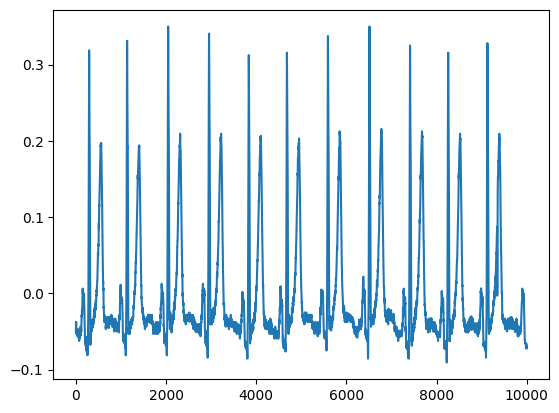

In [6]:
idx = 1
folder_in = '../data/ECGdrugs/'
egrfid = df['EGREFID'].iloc[idx]
drug = df['EXTRT'].iloc[idx]
randid = df['RANDID'].iloc[idx]
filename = f'{folder_in}/raw/{randid}/{egrfid}'
ecg = wfdb.rdsamp(filename, channels=[0])[0]
plt.plot(ecg)
# ecg

In [7]:
class ECGdata(torch.utils.data.Dataset):
    def __init__(self, csv_in, folder_in):
        self.df = pd.read_csv(csv_in)
        self.folder_in = folder_in
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if idx>len(self.df):
            raise IndexError
        egrfid = self.df['EGREFID'].iloc[idx]
        drug = self.df['EXTRT'].iloc[idx]
        randid = self.df['RANDID'].iloc[idx]
        filename = f'{self.folder_in}/raw/{randid}/{egrfid}'
        ecg = wfdb.rdsamp(filename, channels=[0])[0]
        return ecg, int(drug!='Placebo')

In [8]:
data = ECGdata('../data/ECGdrugs/SCR-002.Clinical.Data.csv',\
               '../data/ECGdrugs/')
data[100]

(array([[-0.06375172],
        [-0.04999922],
        [-0.04687766],
        ...,
        [ 0.13437629],
        [ 0.13749786],
        [ 0.1406262 ]]),
 0)

In [9]:
train_size = int(0.8*len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])
len(train_data), len(test_data)

(4185, 1047)

In [10]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = torch.nn.Conv1d(1, 10, 100, stride=10)
        self.dense = torch.nn.Linear( 9910, 2)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=-1)
    
    def forward(self, x):
        # print(x.shape)
        x = self.conv(x)
        # print(x.shape)
        x = self.relu(x)
        x = self.dense(x.view(-1, 9910))
        x = self.softmax(x)
        return x

net = Net().to(device)
z = torch.zeros( (1, 1, 10_000), device=device)
net(z).shape

torch.Size([1, 2])

In [12]:
net = Net().to(device)
z = torch.zeros( (1, 1, 10_000), device=device)
net(z).shape

correct = 0
total = 0
with torch.no_grad():
    for batch_ecg, batch_labels in test_data_loader:
        batch_ecg = batch_ecg.to(device).view(-1, 1, 10_000).float()
        batch_labels = batch_labels.to(device)
        out = net(batch_ecg)
        predicted = torch.argmax(out, 1)
        correct += (predicted==batch_labels).sum()
        total += batch_labels.shape[0]
print(f'Accuracy: {100*correct/total:0.3f}%')


opt = torch.optim.Adam(net.parameters(), lr = 0.001)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([4.0, 1.0]))

Accuracy: 73.161%


Given the class imbalance, a non trained network should perform between 20% and 80% accuracy.

In [13]:
losses = []
train_acc = []
test_acc = []
num_epochs = 30
for epoch in range(1,num_epochs+1):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_ecg, batch_labels in train_data_loader:
        batch_ecg = batch_ecg.to(device).view(-1, 1, 10_000).float()
        batch_labels = batch_labels.to(device)
        out = net(batch_ecg)
        predicted = torch.argmax(out, 1)
        # print(batch_labels.shape)
        # hot_batch_labels = torch.nn.functional.one_hot(batch_labels, 2)
        loss = criterion(out, batch_labels)
        running_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        correct += (predicted==batch_labels).sum()
        total += batch_labels.shape[0]
    losses.append(running_loss)
    train_acc.append(100*correct/total)
    print(f'{epoch}/{num_epochs}: Training Accuracy: {100*correct/total:.03f}%\
 ; Loss: {running_loss:.4e}')
    

    correct = 0
    total = 0
    with torch.no_grad():
        for batch_ecg, batch_labels in test_data_loader:
            batch_ecg = batch_ecg.to(device).view(-1, 1, 10_000).float()
            batch_labels = batch_labels.to(device)
            out = net(batch_ecg)
            predicted = torch.argmax(out, 1)
            correct += (predicted==batch_labels).sum()
            total += batch_labels.shape[0]
    print(f'       Testing Accuracy: {100*correct/total:0.3f}%')
    test_acc.append(100*correct/total)


1/30: Training Accuracy: 59.522% ; Loss: 9.1290e+01
    Testing Accuracy: 78.319%
2/30: Training Accuracy: 62.820% ; Loss: 8.9729e+01
    Testing Accuracy: 74.785%
3/30: Training Accuracy: 61.840% ; Loss: 8.6777e+01
    Testing Accuracy: 67.813%
4/30: Training Accuracy: 67.192% ; Loss: 8.3155e+01
    Testing Accuracy: 64.279%
5/30: Training Accuracy: 70.227% ; Loss: 8.0333e+01
    Testing Accuracy: 56.351%
6/30: Training Accuracy: 72.115% ; Loss: 7.7427e+01
    Testing Accuracy: 55.492%
7/30: Training Accuracy: 73.644% ; Loss: 7.4813e+01
    Testing Accuracy: 54.823%
8/30: Training Accuracy: 76.153% ; Loss: 7.2855e+01
    Testing Accuracy: 66.380%
9/30: Training Accuracy: 76.822% ; Loss: 7.1252e+01
    Testing Accuracy: 61.127%
10/30: Training Accuracy: 78.901% ; Loss: 6.9316e+01
    Testing Accuracy: 56.734%
11/30: Training Accuracy: 80.024% ; Loss: 6.7865e+01
    Testing Accuracy: 60.172%
12/30: Training Accuracy: 80.072% ; Loss: 6.7144e+01
    Testing Accuracy: 56.829%
13/30: Traini

Saving the model

In [14]:
# torch.save(net, 'mymodel.torch')
net = torch.load('mymodel.torch')

[]

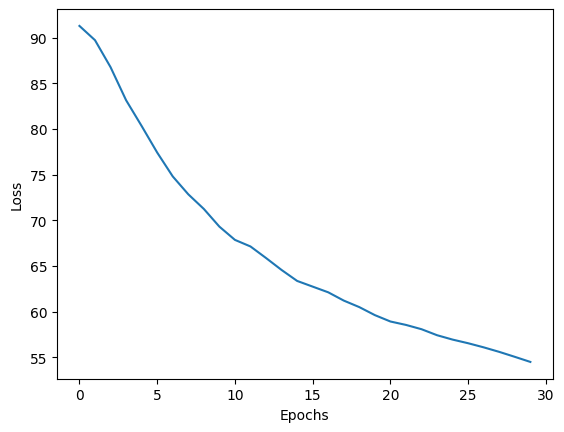

In [18]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

[]

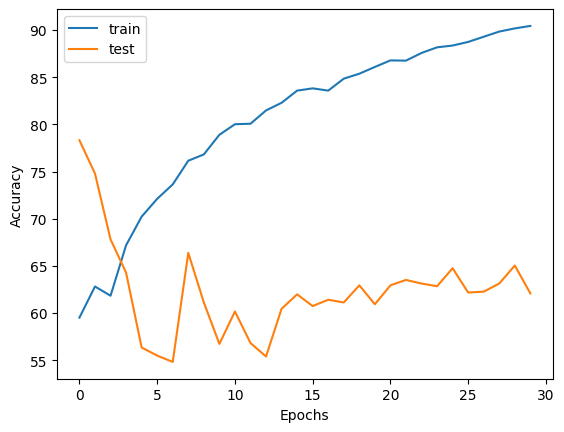

In [15]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.plot()

Homework:
- Analysing the accuracies in training and testing, what can you conclude?
- Try with only dense layers in you model. What happens?
- Try with more convolutional layers in you model. What happens?
- Do you think it is possible to detect the drug from the ECG? Why?